# Anomaly Detection in R

This notebook covers the material in the AI+ Training course on an introduction to fraud and anomaly detection. It goes through three main modules as follows:

1. Data Preparation
2. Probability and Statistical Approaches
3. Machine Learning Approaches

The following code loads all the necessary packages and libraries for the analysis.

In [37]:
# Needed Packages for Analysis #
install.packages("benford.analysis")
install.packages("robustbase")
install.packages("car")
install.packages("stats")
install.packages("FNN")
install.packages("dbscan")
install.packages("randomForest")
install.packages("devtools")
install.packages("isotree")
install.packages("lubridate")
install.packages("circular")
install.packages("dplyr")
install.packages("MASS")
install.packages("ggplot2")
install.packages("e1071")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘stats’ is a base package, and should not be updated”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘textshaping’, ‘ragg’, ‘pkgdown’


Warning message in install.packages("devtools"):
“installation of package ‘textshaping’ had non-zero exit status”
Warning message in install.packages("devtools"):
“installation of package 

In [38]:
# Needed Libraries for Analysis #
library(MASS)
library(benford.analysis)
library(robustbase)
library(car)
library(stats)
library(FNN)
library(dbscan)
library(randomForest)
library(devtools)
library(isotree)
library(lubridate)
library(circular)
library(e1071)
library(ggplot2)
library(dplyr)

## Data Preparation

This module details the area of data preparation for good anomaly detection. Anomaly detection is only as good as the data and the features that you have to detect anomalies. This module covers four main concepts in data preparation:

1. Feature Engineering
2. Recency and Frequency
3. Periodic Means
4. Categorical Feature Engineering

Let's load the dataset we will be working with.

In [39]:
ins <- read.csv("transactions_ins.csv")

head(ins)

,Date,Cust_ID,Transaction,Type,Reward_R,Reward_A,Cov_Limit,Income
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
1,9/10/1977,PSX000100006,IN,T,NA,NA,50000,61000
2,12/31/2005,PSX000100006,CL,T,NA,NA,50000,61000
3,1/17/2006,PSX000100006,RE,T,265,50000,NA,NA
4,12/15/1998,PSX000100010,IN,T,NA,NA,100000,29000
5,6/7/1961,PSX000100013,IN,V,NA,NA,100000,48000
6,6/12/2001,PSX000100013,CL,V,NA,NA,100000,48000


In [40]:
summary(ins)

     Date             Cust_ID          Transaction            Type          
 Length:278877      Length:278877      Length:278877      Length:278877     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
                                                                            
    Reward_R         Reward_A         Cov_Limit           Income      
 Min.   :100.0    Min.   :      0   Min.   :  50000   Min.   : 15000  
 1st Qu.:207.0    1st Qu.: 100000   1st Qu.: 100000   1st Qu.: 34422  
 Median :314.0    Median : 150000   Median : 150000   Median : 50000  
 Mean   :315.7    Mean   : 224725   Mean   : 205779   Mean   : 53364  
 3rd Qu.:421.0    3rd Qu.: 30

In [41]:
ins$Date <- as.Date(ins$Date, "%m/%d/%Y")

### Feature Engineering

The concept of feature engineering is vitally important to anomaly detection. In my personal experience, the best features aren't just automatically generated by a computer, but thought up by a knowledgable individual working on the problem.

We are going to roll up the transactions to be one per individual. Here are some basic features when rolling up our transactions that might be important when discovering fraud:
- Final income
- Time between claim and reward
- Coverage limit to income ratio at claim

Think of some more of your own!

Let's create final income.

In [42]:
ins_income <- ins %>% filter(Transaction == 'CL') %>% select(Cust_ID, Cov_Limit, Income)

head(ins_income, n = 10)

,Cust_ID,Cov_Limit,Income
,<chr>,<int>,<int>
1,PSX000100006,50000,61000
2,PSX000100013,100000,48000
3,PSX000100073,100000,35000
4,PSX000100081,50000,69000
5,PSX000100122,150000,105000
6,PSX000100146,100000,38000
7,PSX000100231,400000,79155
8,PSX000100236,250000,54738
9,PSX000100286,150000,95973


Now, let's create time in between claim and reward.

In [43]:
ins_time <- ins %>% filter(Transaction == 'CL' | Transaction == 'RE')

head(ins_time, n = 10)

,Date,Cust_ID,Transaction,Type,Reward_R,Reward_A,Cov_Limit,Income
,<date>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
1,2005-12-31,PSX000100006,CL,T,NA,NA,50000,61000
2,2006-01-17,PSX000100006,RE,T,265,50000,NA,NA
3,2001-06-12,PSX000100013,CL,V,NA,NA,100000,48000
4,2001-07-11,PSX000100013,RE,V,265,100000,NA,NA
5,2004-01-21,PSX000100073,CL,V,NA,NA,100000,35000
6,2004-02-14,PSX000100073,RE,V,450,100000,NA,NA
7,2009-06-28,PSX000100081,CL,T,NA,NA,50000,69000
8,2009-07-26,PSX000100081,RE,T,543,0,NA,NA
9,1991-08-23,PSX000100122,CL,T,NA,NA,150000,105000


In [44]:
ins_time$diff <- ins_time$Date - lag(ins_time$Date)

head(ins_time, n = 10)

,Date,Cust_ID,Transaction,Type,Reward_R,Reward_A,Cov_Limit,Income,diff
,<date>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<drtn>
1,2005-12-31,PSX000100006,CL,T,NA,NA,50000,61000,NA days
2,2006-01-17,PSX000100006,RE,T,265,50000,NA,NA,17 days
3,2001-06-12,PSX000100013,CL,V,NA,NA,100000,48000,-1680 days
4,2001-07-11,PSX000100013,RE,V,265,100000,NA,NA,29 days
5,2004-01-21,PSX000100073,CL,V,NA,NA,100000,35000,924 days
6,2004-02-14,PSX000100073,RE,V,450,100000,NA,NA,24 days
7,2009-06-28,PSX000100081,CL,T,NA,NA,50000,69000,1961 days
8,2009-07-26,PSX000100081,RE,T,543,0,NA,NA,28 days
9,1991-08-23,PSX000100122,CL,T,NA,NA,150000,105000,-6547 days


In [45]:
ins_time <- ins_time %>% filter(Transaction == 'RE') %>% select(-Cov_Limit, -Income, -Transaction)

head(ins_time, n = 10)

,Date,Cust_ID,Type,Reward_R,Reward_A,diff
,<date>,<chr>,<chr>,<int>,<int>,<drtn>
1,2006-01-17,PSX000100006,T,265,50000,17 days
2,2001-07-11,PSX000100013,V,265,100000,29 days
3,2004-02-14,PSX000100073,V,450,100000,24 days
4,2009-07-26,PSX000100081,T,543,0,28 days
5,1991-09-08,PSX000100122,T,200,150000,16 days
6,2009-04-21,PSX000100146,T,275,100000,20 days
7,2008-05-05,PSX000100231,V,405,400000,25 days
8,1970-10-06,PSX000100236,T,469,250000,24 days
9,2003-03-20,PSX000100286,V,337,150000,22 days


Lastly, let's combine our datasets from above and create coverage limit to income ratio.

In [46]:
ins_feat <- merge(ins_time, ins_income)

head(ins_feat, n = 10)

,Cust_ID,Date,Type,Reward_R,Reward_A,diff,Cov_Limit,Income
,<chr>,<date>,<chr>,<int>,<int>,<drtn>,<int>,<int>
1,PSX000100006,2006-01-17,T,265,50000,17 days,50000,61000
2,PSX000100013,2001-07-11,V,265,100000,29 days,100000,48000
3,PSX000100073,2004-02-14,V,450,100000,24 days,100000,35000
4,PSX000100081,2009-07-26,T,543,0,28 days,50000,69000
5,PSX000100122,1991-09-08,T,200,150000,16 days,150000,105000
6,PSX000100146,2009-04-21,T,275,100000,20 days,100000,38000
7,PSX000100231,2008-05-05,V,405,400000,25 days,400000,79155
8,PSX000100236,1970-10-06,T,469,250000,24 days,250000,54738
9,PSX000100286,2003-03-20,V,337,150000,22 days,150000,95973


In [47]:
ins_feat$Cov_Income_Ratio <- ins_feat$Cov_Limit / ins_feat$Income

head(ins_feat, n = 10)

,Cust_ID,Date,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio
,<chr>,<date>,<chr>,<int>,<int>,<drtn>,<int>,<int>,<dbl>
1,PSX000100006,2006-01-17,T,265,50000,17 days,50000,61000,0.8196721
2,PSX000100013,2001-07-11,V,265,100000,29 days,100000,48000,2.0833333
3,PSX000100073,2004-02-14,V,450,100000,24 days,100000,35000,2.8571429
4,PSX000100081,2009-07-26,T,543,0,28 days,50000,69000,0.7246377
5,PSX000100122,1991-09-08,T,200,150000,16 days,150000,105000,1.4285714
6,PSX000100146,2009-04-21,T,275,100000,20 days,100000,38000,2.6315789
7,PSX000100231,2008-05-05,V,405,400000,25 days,400000,79155,5.0533763
8,PSX000100236,1970-10-06,T,469,250000,24 days,250000,54738,4.5672111
9,PSX000100286,2003-03-20,V,337,150000,22 days,150000,95973,1.5629396


### Recency and Frequency

We will look at recency and frequency one at a time. Let's start with recency. For ease of application, let's use all the differences in time for all customers to build our recency exponential distribution instead of building one per customer.

Specifically, we will look at recency of changes in policy.

In [48]:
ins_rec <- ins

ins_rec$diff <- ins_rec$Date - lag(ins_rec$Date)

ins_rec <- ins_rec %>% filter(Transaction == 'CH')

head(ins_rec, n = 10)

,Date,Cust_ID,Transaction,Type,Reward_R,Reward_A,Cov_Limit,Income,diff
,<date>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<drtn>
1,1986-04-16,PSX000100058,CH,T,NA,NA,250000,130280,3958 days
2,1997-08-30,PSX000100140,CH,W,NA,NA,150000,87073,2440 days
3,2007-10-26,PSX000100167,CH,V,NA,NA,300000,63041,7455 days
4,2008-11-20,PSX000100167,CH,V,NA,NA,350000,66722,391 days
5,2010-10-03,PSX000100167,CH,V,NA,NA,550000,68743,682 days
6,1996-11-17,PSX000100168,CH,W,NA,NA,350000,68371,3160 days
7,1998-03-13,PSX000100168,CH,W,NA,NA,500000,82691,481 days
8,2012-03-02,PSX000100217,CH,V,NA,NA,300000,43560,8420 days
9,1983-04-06,PSX000100231,CH,V,NA,NA,300000,75657,3412 days


In [49]:
exp_rec <- fitdistr(as.numeric(ins_rec$diff), "exponential")
exp_rec$estimate

rate 
0.0002539779

In [50]:
ins_rec$rec <- exp(-exp_rec$estimate*as.numeric(ins_rec$diff))

head(ins_rec, n = 10)

,Date,Cust_ID,Transaction,Type,Reward_R,Reward_A,Cov_Limit,Income,diff,rec
,<date>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<drtn>,<dbl>
1,1986-04-16,PSX000100058,CH,T,NA,NA,250000,130280,3958 days,0.3659552
2,1997-08-30,PSX000100140,CH,W,NA,NA,150000,87073,2440 days,0.5381026
3,2007-10-26,PSX000100167,CH,V,NA,NA,300000,63041,7455 days,0.1505583
4,2008-11-20,PSX000100167,CH,V,NA,NA,350000,66722,391 days,0.9054662
5,2010-10-03,PSX000100167,CH,V,NA,NA,550000,68743,682 days,0.8409586
6,1996-11-17,PSX000100168,CH,W,NA,NA,350000,68371,3160 days,0.4481757
7,1998-03-13,PSX000100168,CH,W,NA,NA,500000,82691,481 days,0.8850038
8,2012-03-02,PSX000100217,CH,V,NA,NA,300000,43560,8420 days,0.1178322
9,1983-04-06,PSX000100231,CH,V,NA,NA,300000,75657,3412 days,0.4203900


In [51]:
ins_rec <- ins_rec %>% group_by(Cust_ID) %>% summarise(rec_avg = mean(rec))

head(ins_rec, n = 10)

Cust_ID,rec_avg
<chr>,<dbl>
PSX000100058,0.3659552
PSX000100140,0.5381026
PSX000100167,0.6323277
PSX000100168,0.6665897
PSX000100217,0.1178322
PSX000100231,0.2669953
PSX000100234,0.2088202
PSX000100236,0.4698555
PSX000100286,0.4532121


For our data, frequency of changes in policy might also be a flag of fraud.

In [52]:
ins_changes <- ins %>% group_by(Cust_ID) %>% count(Transaction == 'CH')

head(ins_changes, n = 10)

head(ins_changes[order(-ins_changes$n),], n = 10)

Cust_ID,"Transaction == ""CH""",n
<chr>,<lgl>,<int>
PSX000100006,FALSE,3
PSX000100010,FALSE,1
PSX000100013,FALSE,3
PSX000100016,FALSE,1
PSX000100027,FALSE,1
PSX000100037,FALSE,1
PSX000100058,FALSE,1
PSX000100058,TRUE,1
PSX00010006,FALSE,1


Cust_ID,"Transaction == ""CH""",n
<chr>,<lgl>,<int>
PSX000704539,TRUE,18
PSX000602071,TRUE,16
PSX00096928,TRUE,16
PSX000842653,TRUE,15
PSX000112259,TRUE,14
PSX00025304,TRUE,14
PSX000375963,TRUE,14
PSX000474725,TRUE,14
PSX000114055,TRUE,13


In [53]:
ins_changes$num_changes <- ifelse(ins_changes[,2] == TRUE, ins_changes$n, 0)

head(ins_changes, n = 10)

ins_changes <- ins_changes %>% select(Cust_ID, num_changes)

Cust_ID,"Transaction == ""CH""",n,num_changes
<chr>,<lgl>,<int>,"<dbl[,1]>"
PSX000100006,FALSE,3,0
PSX000100010,FALSE,1,0
PSX000100013,FALSE,3,0
PSX000100016,FALSE,1,0
PSX000100027,FALSE,1,0
PSX000100037,FALSE,1,0
PSX000100058,FALSE,1,0
PSX000100058,TRUE,1,1
PSX00010006,FALSE,1,0


In [54]:
ins_changes <- ins_changes %>% group_by(Cust_ID) %>% filter(duplicated(Cust_ID) | n()==1) %>% select(Cust_ID, num_changes)

head(ins_changes, n = 10)

Cust_ID,num_changes
<chr>,"<dbl[,1]>"
PSX000100006,0
PSX000100010,0
PSX000100013,0
PSX000100016,0
PSX000100027,0
PSX000100037,0
PSX000100058,1
PSX00010006,0
PSX000100073,0


Let's combine these recency and frequency features into our features dataset.

In [55]:
ins_feat <- merge(ins_feat, ins_rec)

head(ins_feat, n = 10)

,Cust_ID,Date,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,rec_avg
,<chr>,<date>,<chr>,<int>,<int>,<drtn>,<int>,<int>,<dbl>,<dbl>
1,PSX000100231,2008-05-05,V,405,400000,25 days,400000,79155,5.053376,0.26699530
2,PSX000100236,1970-10-06,T,469,250000,24 days,250000,54738,4.567211,0.46985547
3,PSX000100286,2003-03-20,V,337,150000,22 days,150000,95973,1.562940,0.45321212
4,PSX00010030,1980-01-09,T,377,350000,23 days,350000,37725,9.277667,0.69281103
5,PSX000100314,1994-12-26,W,144,750000,24 days,750000,72816,10.299934,0.62692482
6,PSX000100337,2007-01-28,W,445,400000,11 days,400000,114879,3.481924,0.86874665
7,PSX000100470,1991-06-11,T,386,800000,22 days,800000,74437,10.747343,0.69506669
8,PSX000100555,2011-02-08,T,519,0,23 days,650000,33238,19.555930,0.43874262
9,PSX000100585,2005-09-27,V,264,300000,23 days,300000,26998,11.111934,0.07868377


In [56]:
ins_feat <- merge(ins_feat, ins_changes)

head(ins_feat, n = 10)

,Cust_ID,Date,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,rec_avg,num_changes
,<chr>,<date>,<chr>,<int>,<int>,<drtn>,<int>,<int>,<dbl>,<dbl>,"<dbl[,1]>"
1,PSX000100231,2008-05-05,V,405,400000,25 days,400000,79155,5.053376,0.26699530,2
2,PSX000100236,1970-10-06,T,469,250000,24 days,250000,54738,4.567211,0.46985547,1
3,PSX000100286,2003-03-20,V,337,150000,22 days,150000,95973,1.562940,0.45321212,1
4,PSX00010030,1980-01-09,T,377,350000,23 days,350000,37725,9.277667,0.69281103,1
5,PSX000100314,1994-12-26,W,144,750000,24 days,750000,72816,10.299934,0.62692482,4
6,PSX000100337,2007-01-28,W,445,400000,11 days,400000,114879,3.481924,0.86874665,1
7,PSX000100470,1991-06-11,T,386,800000,22 days,800000,74437,10.747343,0.69506669,4
8,PSX000100555,2011-02-08,T,519,0,23 days,650000,33238,19.555930,0.43874262,3
9,PSX000100585,2005-09-27,V,264,300000,23 days,300000,26998,11.111934,0.07868377,1


### Periodic Mean

Our insurance data doesn't have any hourly information where this periodic mean would prove useful.

Here is an example with random data to help us visualize the problem at hand.

In [57]:
set.seed(12345)
timestamp <- as.POSIXlt("2020-02-03 00:30:00") + rnorm(1000, 0, 60*60*4)
head(timestamp)

timestamp_hms <- strftime(timestamp, format="%H:%M:%S")
ts <- as.numeric(hms(timestamp_hms))/3600
mean_a <- mean(ts)

print(mean_a)

[1] "2020-02-03 02:50:31 UTC" "2020-02-03 03:20:16 UTC"
[3] "2020-02-03 00:03:46 UTC" "2020-02-02 22:41:09 UTC"
[5] "2020-02-03 02:55:24 UTC" "2020-02-02 17:13:41 UTC"

[1] 11.00466


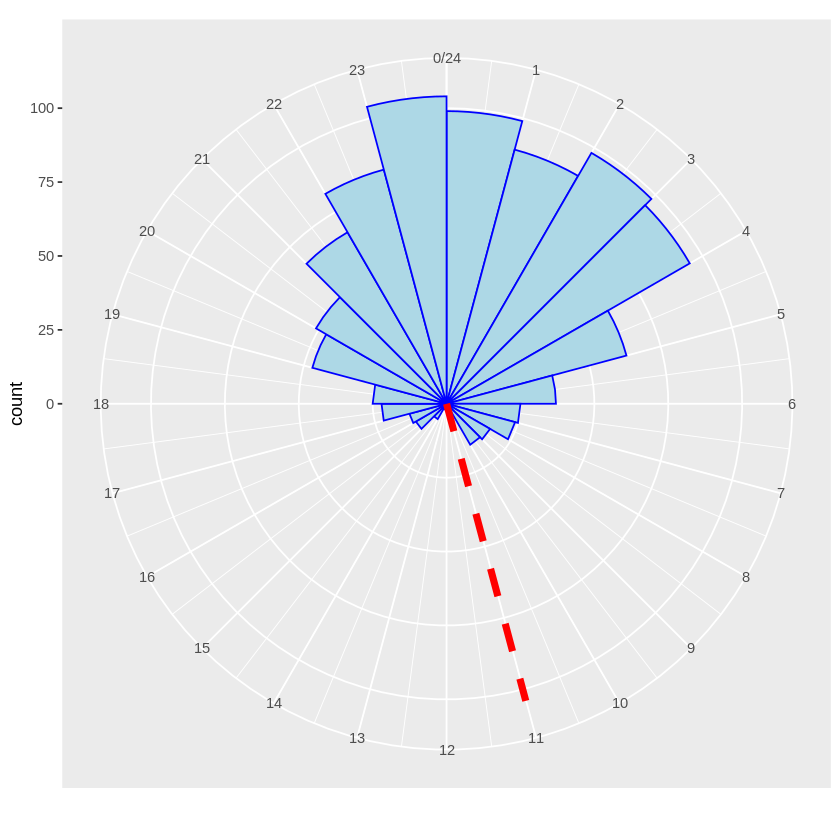

In [58]:
clock <- ggplot(data.frame(ts), aes(x = ts)) +
  geom_histogram(breaks = seq(0, 24), colour = "blue", fill = "lightblue") +
  coord_polar() + scale_x_continuous("", limits = c(0, 24), breaks = seq(0, 24))

clock + geom_vline(xintercept = mean_a,
                   linetype = 2, color = "red", size = 2)

In [59]:
ts <- circular(ts, units = "hours", template = "clock24")
head(ts)
estimates <- mle.vonmises(ts)
mean_p <- estimates$mu %% 24
concentration <- estimates$kappa

print(mean_p)

Circular Data: 
Type = angles 
Units = hours 
Template = clock24 
Modulo = asis 
Zero = 1.570796 
Rotation = clock 
[1]  2.84194444  3.33777778  0.06277778 22.68583333  2.92333333 17.22805556

Circular Data: 
Type = angles 
Units = hours 
Template = clock24 
Modulo = asis 
Zero = 1.570796 
Rotation = clock 
[1] 0.7032131


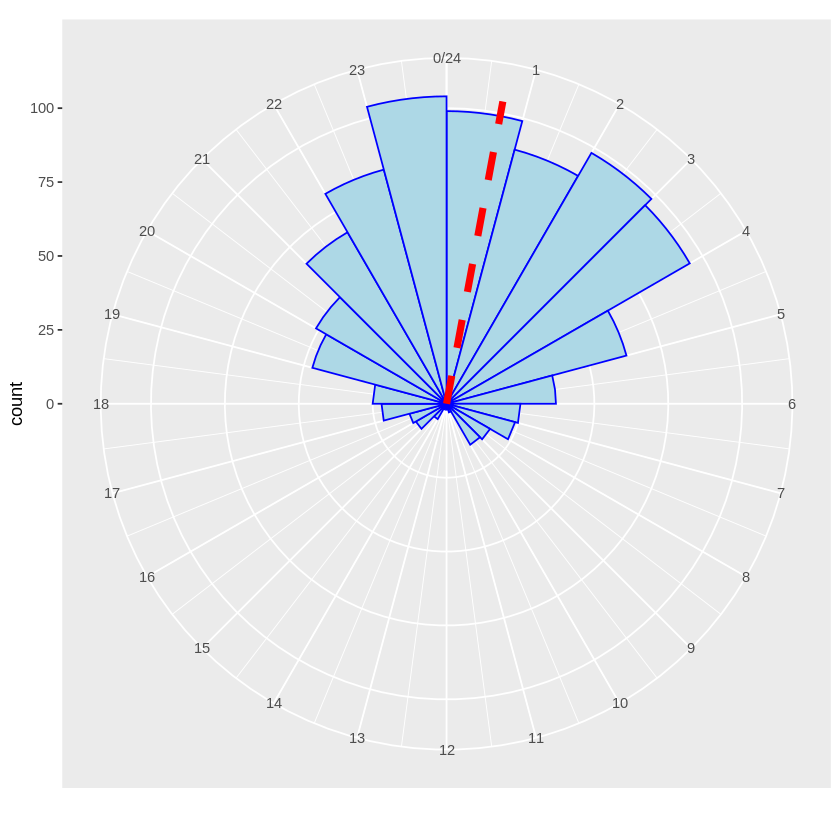

In [60]:
clock + geom_vline(xintercept = mean_p,
                   linetype = 2, color = "red", size = 2)

### Categorical Feature Engineering

Feature engineering doesn't stop with just continuous variables in transactional data. We need to account for categorical features as well.

In our data, the reward reason (Reward_R) variable is categorical. It has numerical representations for reasons of passing that are given on the life insurance policy. Some of these reasons are approved - life insurance policy is paid out. However, not all reasons of passing are covered so the policy isn't paid out in those scenarios.

In [61]:
length(unique(ins_feat$Reward_R))

[1] 480

Instead of having 480 possible categories, let combine these into two groups - approved and rejected reasons - based on the reward amount. If the reward amount was 0, then the reason was not covered by the policy.

In [62]:
ins_feat$Reward_Y <- ifelse(ins_feat$Reward_A > 0, 'Y', 'N')

head(ins_feat, n = 10)

,Cust_ID,Date,Type,Reward_R,Reward_A,diff,Cov_Limit,Income,Cov_Income_Ratio,rec_avg,num_changes,Reward_Y
,<chr>,<date>,<chr>,<int>,<int>,<drtn>,<int>,<int>,<dbl>,<dbl>,"<dbl[,1]>",<chr>
1,PSX000100231,2008-05-05,V,405,400000,25 days,400000,79155,5.053376,0.26699530,2,Y
2,PSX000100236,1970-10-06,T,469,250000,24 days,250000,54738,4.567211,0.46985547,1,Y
3,PSX000100286,2003-03-20,V,337,150000,22 days,150000,95973,1.562940,0.45321212,1,Y
4,PSX00010030,1980-01-09,T,377,350000,23 days,350000,37725,9.277667,0.69281103,1,Y
5,PSX000100314,1994-12-26,W,144,750000,24 days,750000,72816,10.299934,0.62692482,4,Y
6,PSX000100337,2007-01-28,W,445,400000,11 days,400000,114879,3.481924,0.86874665,1,Y
7,PSX000100470,1991-06-11,T,386,800000,22 days,800000,74437,10.747343,0.69506669,4,Y
8,PSX000100555,2011-02-08,T,519,0,23 days,650000,33238,19.555930,0.43874262,3,N
9,PSX000100585,2005-09-27,V,264,300000,23 days,300000,26998,11.111934,0.07868377,1,Y


## Probability and Statistical Approaches

This module details the area of probability and statistical approaches to anomaly detection. Classical probability and statistical approaches to anomaly detection are a great foundation and are still widely used and useful in detecting anomalies. This module covers four main concepts in probability and statistical approaches to anomaly detection:

1. Benford's Law
2. Z-scores and Robust Z-scores
3. IQR Rule and It's Adjustment
4. Mahalanobis Distances

### Benford's Law

We don't have addresses in our data so it makes it hard to see if someone applied for a life insurance policy using fake information. However, let's see how we would apply that to data.

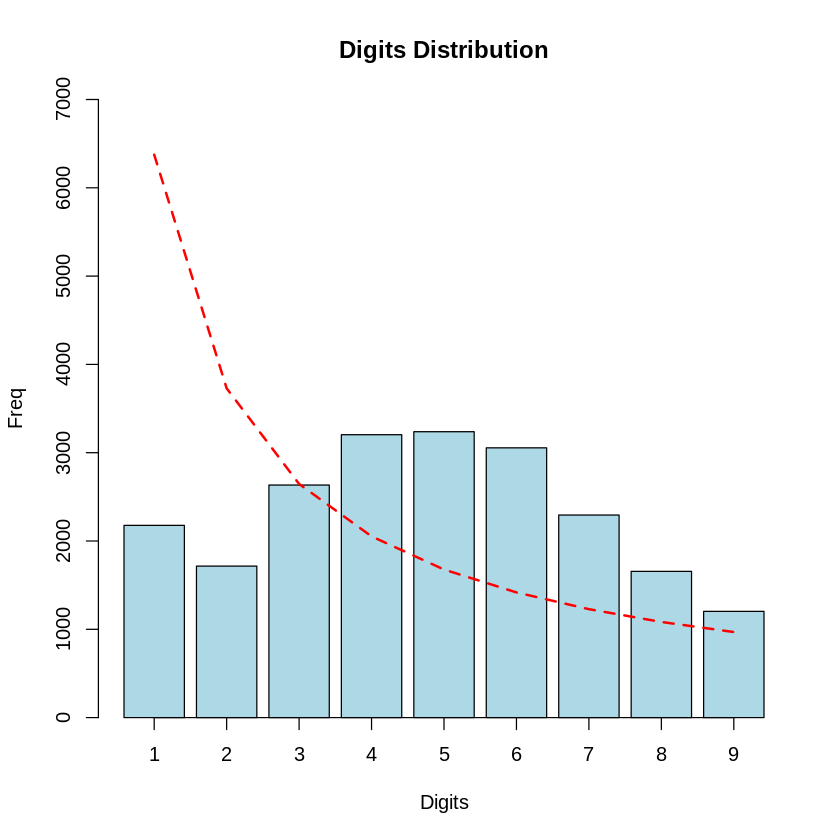

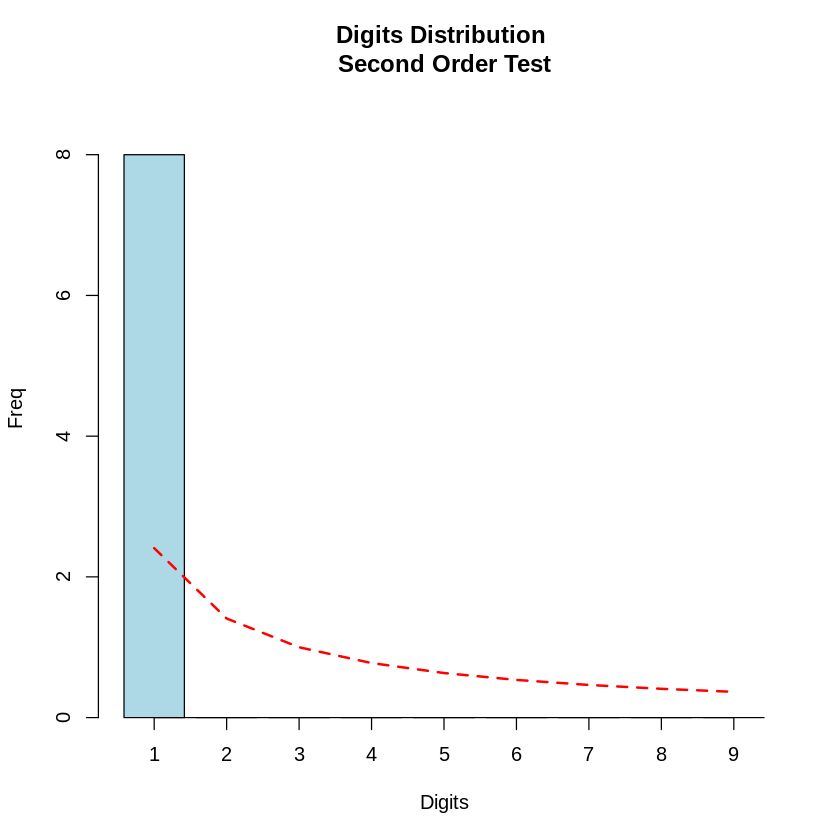

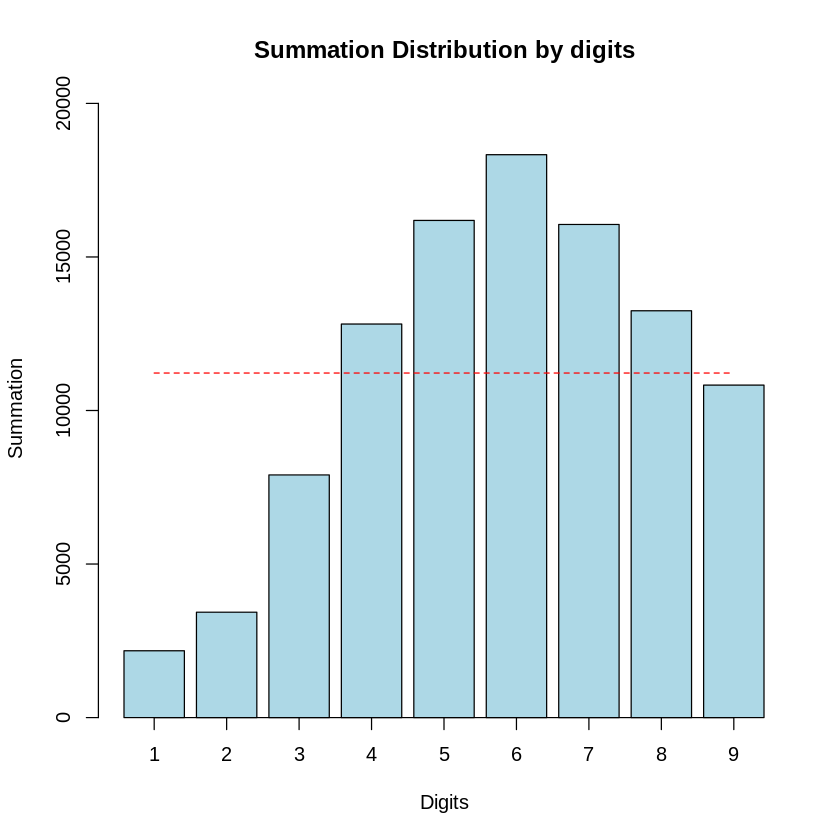

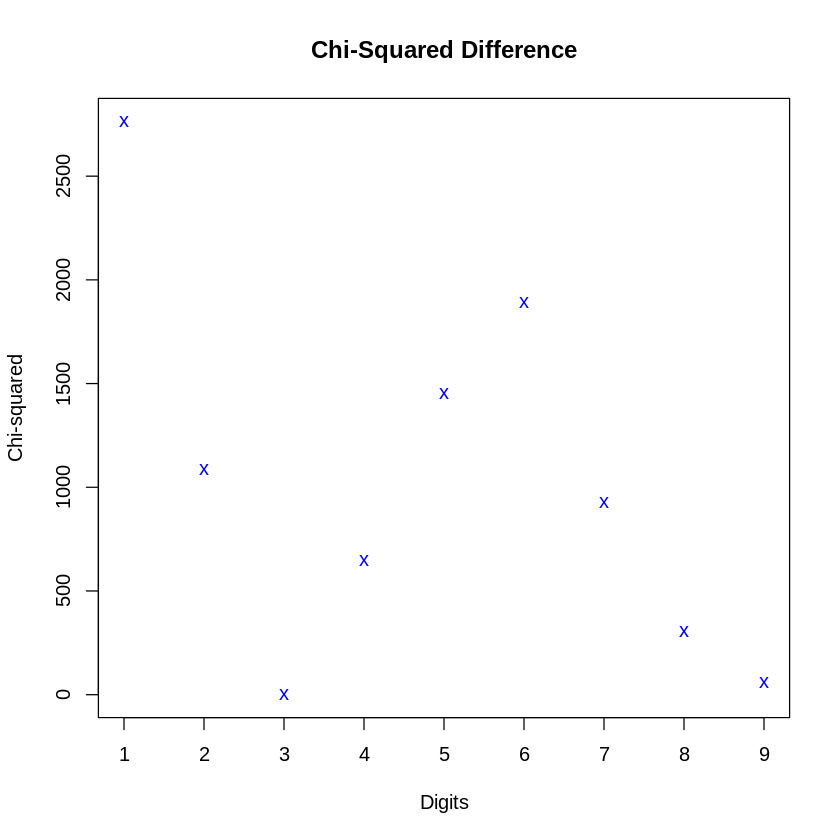

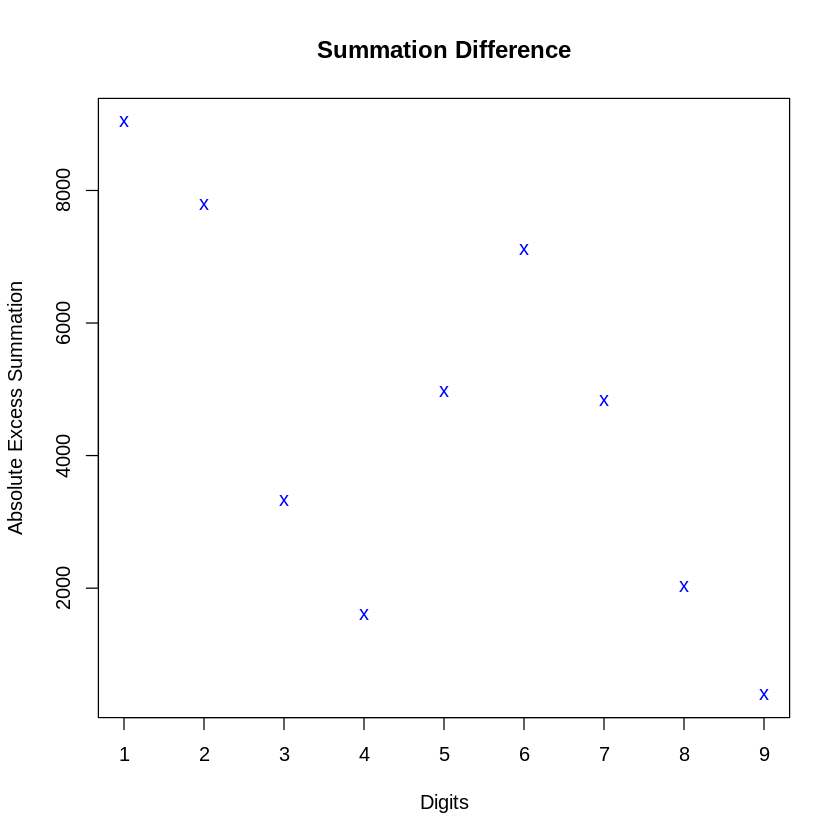


	Pearson's Chi-squared test

data:  rewarddigit1
X-squared = 9126.3, df = 8, p-value < 2.2e-16


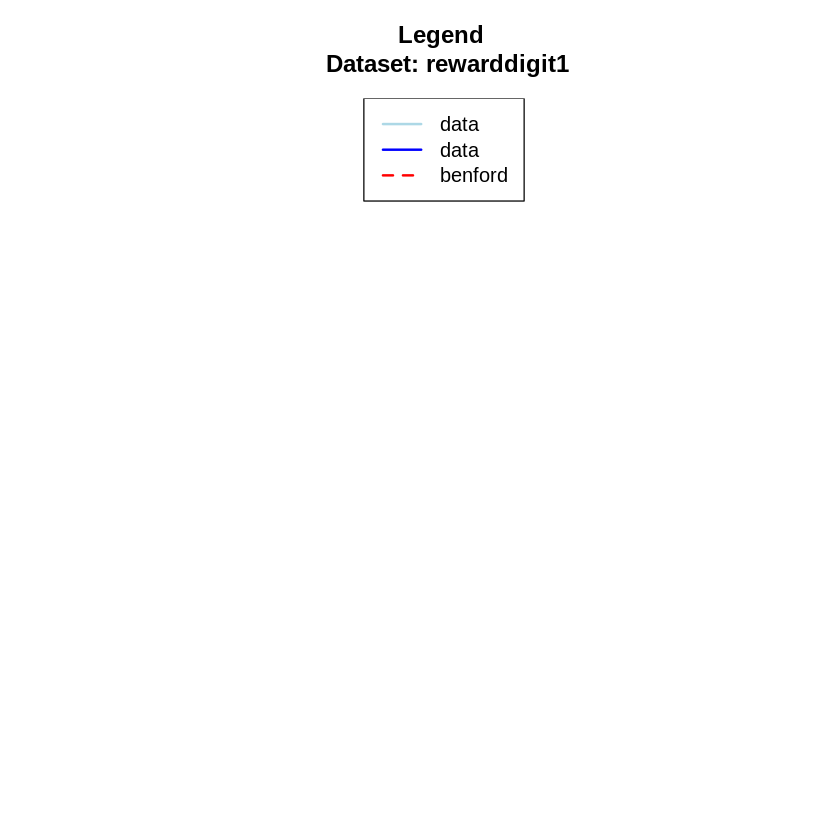

In [63]:
rewarddigit1 <- as.numeric(substring(ins_feat$Income, first = 1, last = 1))
ben <- benford(rewarddigit1, number.of.digits = 1)

plot(ben, multiple = FALSE)
chisq(ben)

### Z-Scores and Robust Z-scores

We want to evaluate if we have an observation far away from "normal" in our coverage to income ratio at time of claim. We are looking for really large life insurance coverage limits when income is not very high - a large ratio between the two.

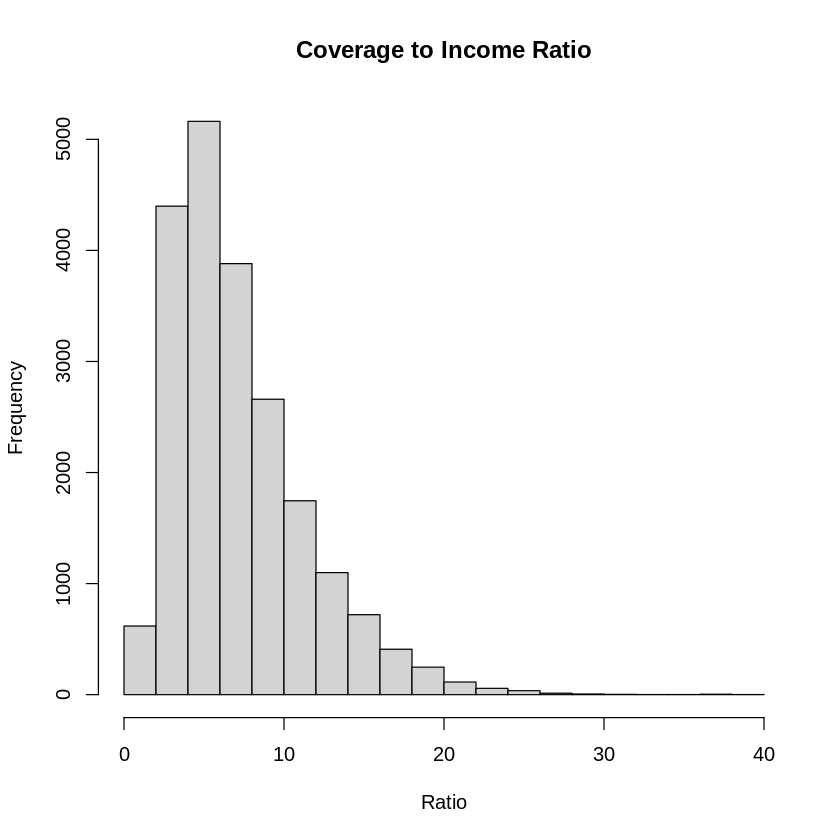

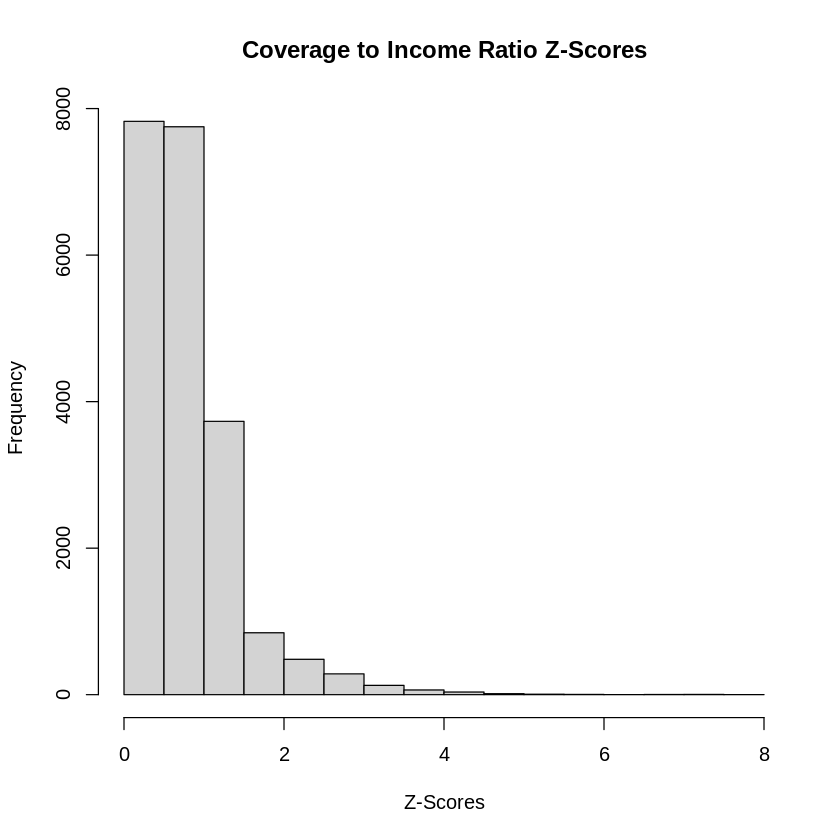

In [64]:
hist(ins_feat$Cov_Income_Ratio, main = "Coverage to Income Ratio", xlab = "Ratio")
x <- ins_feat$Cov_Income_Ratio

ins_feat$Z_Cov_Income_Ratio <- abs((x - mean(x))/sd(x))
hist(ins_feat$Z_Cov_Income_Ratio, main = "Coverage to Income Ratio Z-Scores", xlab = "Z-Scores")

In [65]:
length(which(ins_feat$Z_Cov_Income_Ratio > 3))

[1] 256

Let's switch to using the robust z-score calculation instead.

In [66]:
mad(x)

[1] 3.580728

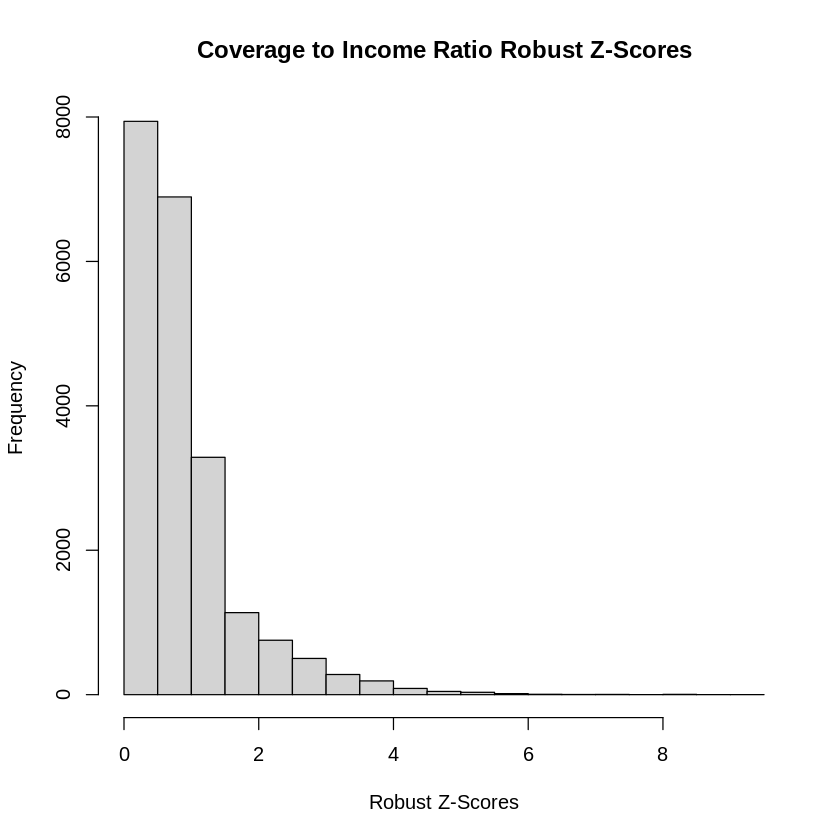

In [67]:
ins_feat$RZ_Cov_Income_Ratio <- abs((x - median(x))/mad(x))
hist(ins_feat$RZ_Cov_Income_Ratio, main = "Coverage to Income Ratio Robust Z-Scores", xlab = "Robust Z-Scores")

In [68]:
length(which(ins_feat$RZ_Cov_Income_Ratio > 3))

[1] 665

### IQR Rule and It's Adjustment

Another univariate approach to looking for outliers is the IQR Rule. However, the IQR Rule really works best for symmetric distributions. For our coverage limit to income ratio variable we know this isn't symmetric based on our above plots

The default of 'doScale' is FALSE now for stability;
  set options(mc_doScale_quiet=TRUE) to suppress this (once per session) message



[1] 610

[1] 84

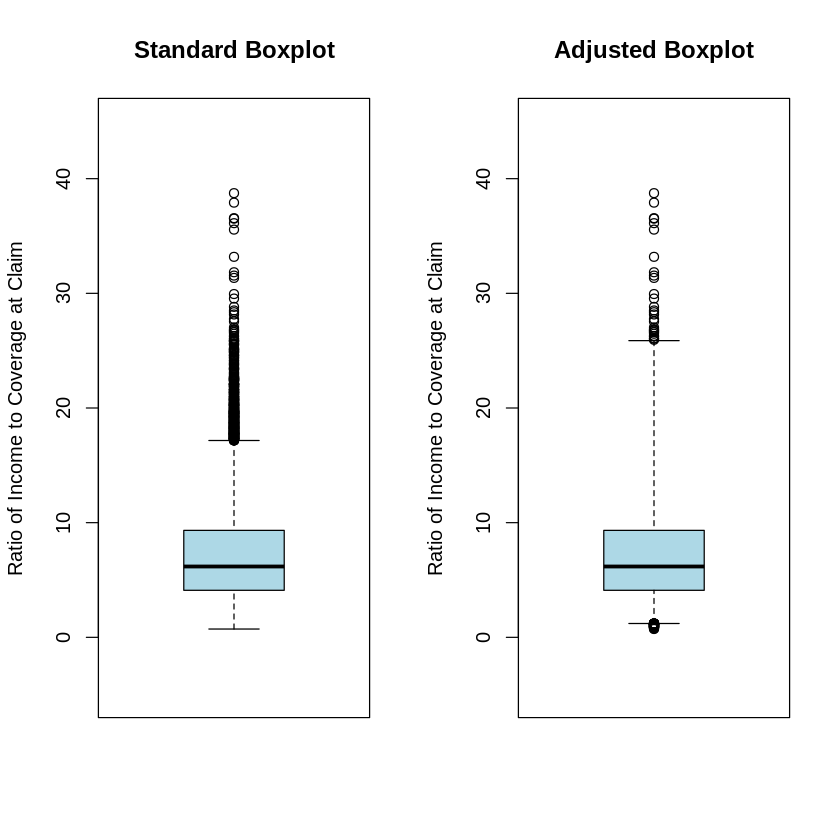

In [69]:
par(mfrow = c(1,2))

bp <- boxplot(ins_feat$Cov_Income_Ratio,
              col = "lightblue",
              main = "Standard Boxplot",
              ylab = "Ratio of Income to Coverage at Claim",
              ylim = c(-5, 45))

adjbp <- adjbox(ins_feat$Cov_Income_Ratio,
                col = "lightblue",
                main = "Adjusted Boxplot",
                ylab = "Ratio of Income to Coverage at Claim",
                ylim = c(-5, 45))

length(bp$out)
length(adjbp$out)

par(mfrow = c(1,1))

### Mahalanobis Distances

When looking at two or more variables at the same time, we need to account for multiple dimensions. Mahalanobis distances are a multivariate version of the z-score.

Let compare the two variables of average recency of changes in policies and frequency of these changes.

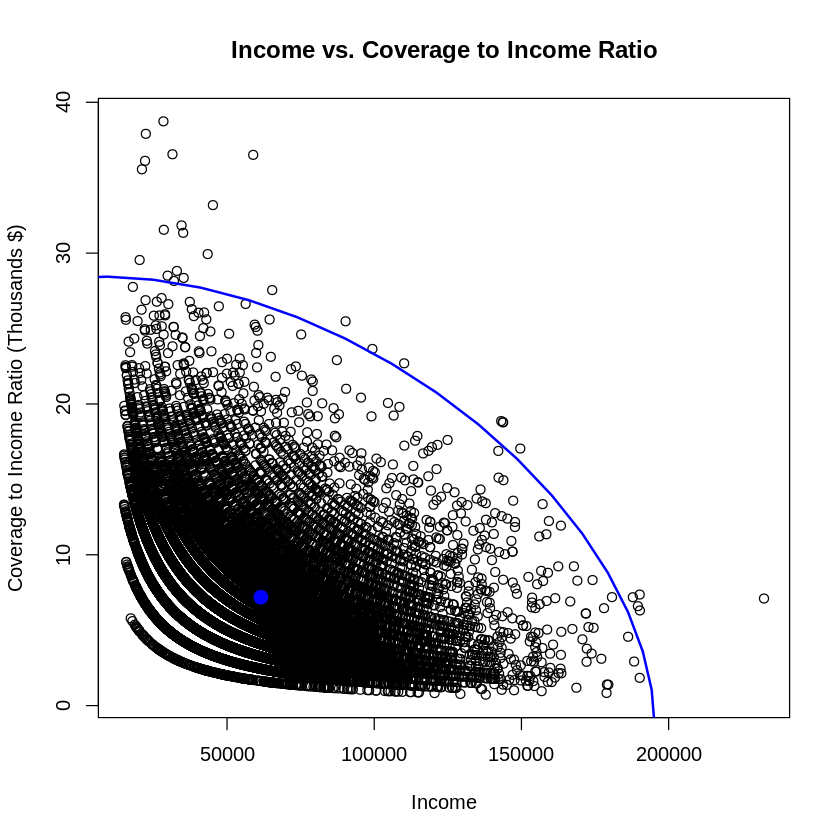

In [70]:
plot(x = ins_feat$Income, y = ins_feat$Cov_Income_Ratio,
     main = "Income vs. Coverage to Income Ratio",
     xlab = "Income",
     ylab = "Coverage to Income Ratio (Thousands $)")

df <- data.frame(income = ins_feat$Income,
                 CIRatio = ins_feat$Cov_Income_Ratio)

rad <- sqrt(qchisq(0.9999975, ncol(df)))
ellipse(center = colMeans(df, na.rm = TRUE),
        shape = cov(df), radius = rad, col = "blue")

Just like with z-scores, we have a robust version of the Mahalanobis distances.

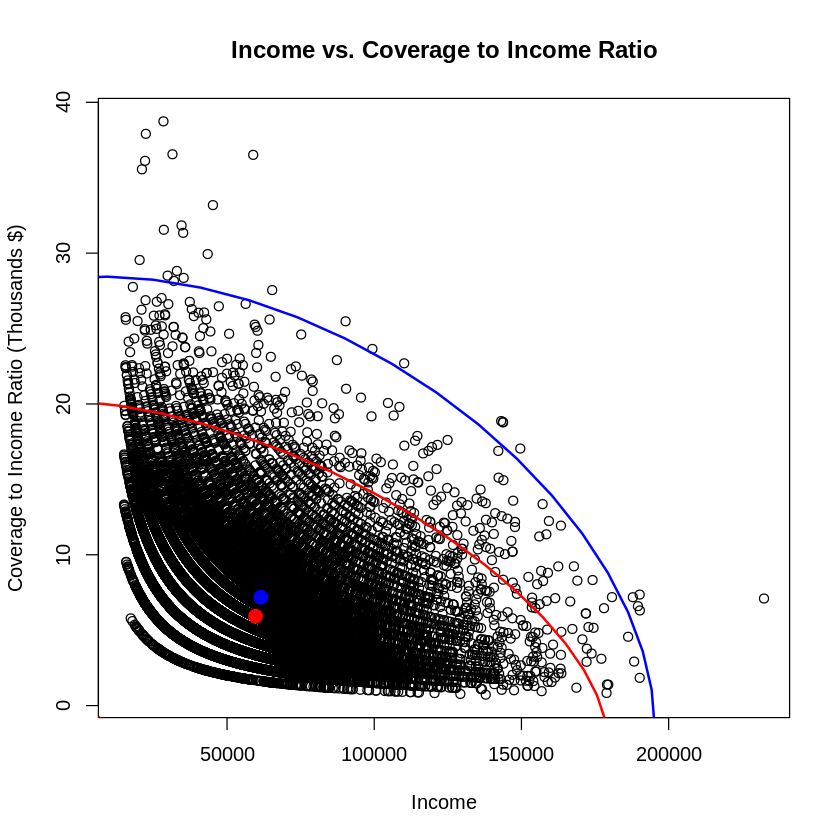

In [71]:
mcdresult <- covMcd(df)
robustcenter <- mcdresult$center
robustcov <- mcdresult$cov

plot(x = ins_feat$Income, y = ins_feat$Cov_Income_Ratio,
     main = "Income vs. Coverage to Income Ratio",
     xlab = "Income",
     ylab = "Coverage to Income Ratio (Thousands $)")

rad <- sqrt(qchisq(0.9999975, ncol(df)))
ellipse(center = colMeans(df, na.rm = TRUE),
        shape = cov(df), radius = rad, col = "blue")

rad <- sqrt(qchisq(0.9999975, ncol(df)))
ellipse(center = robustcenter, shape = robustcov,
        radius = rad, col = "red")

## Machine Learning Approaches

This module details the area of machine learning approaches to anomaly detection. With the enhancements and creation of machine learning approaches to modeling, these same techniques form the foundation of more advanced anomaly detection methods. This module covers five main concepts in machine learning approaches to anomaly detection:

1. k-Nearest Neighbors (k-NN)
2. Local Outlier Factor (LOF)
3. Isolation Forests
4. Classifier-Adjusted Density Estimation (CADE)
5. One-Class Support Vector Machines (SVM)

### k-Nearest Neighbors

Instead of looking at more statistical approaches, we can directly look at the average distance each point is from its k-nearest neighbors.

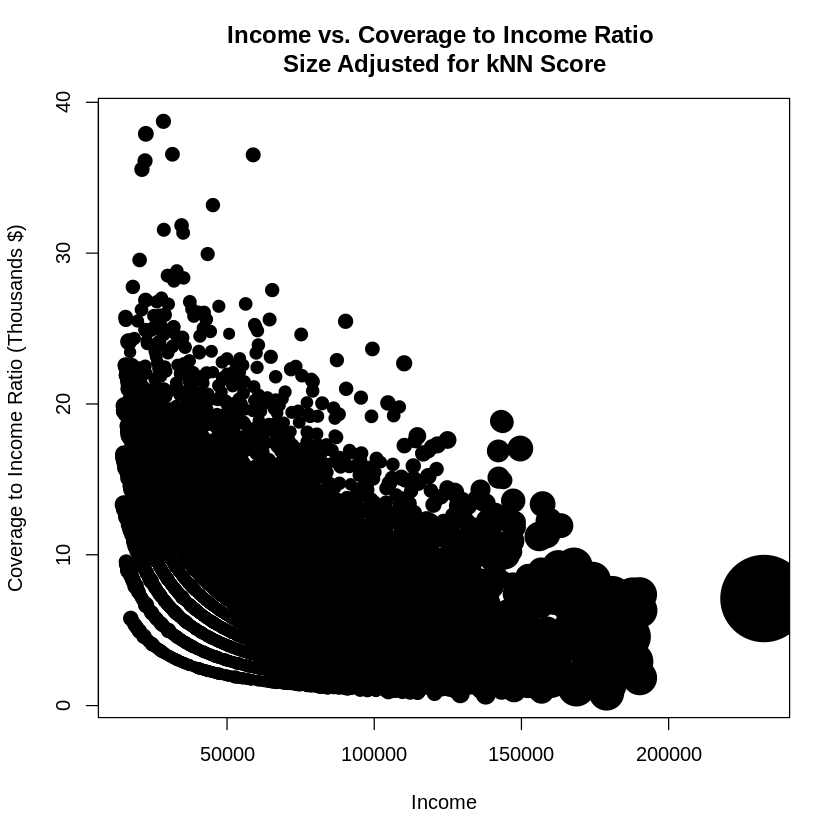

In [72]:
df <- data.frame(income = ins_feat$Income,
                 CIRatio = ins_feat$Cov_Income_Ratio)

ins_knn <- get.knn(data = df, k = 5)

df$knn_score <- rowMeans(ins_knn$nn.dist)

plot(CIRatio ~ income, data = df, cex = (knn_score)^(0.25), pch = 20,
     main = "Income vs. Coverage to Income Ratio \nSize Adjusted for kNN Score",
     xlab = "Income",
     ylab = "Coverage to Income Ratio (Thousands $)")

### Local Outlier Factor (LOF)

Let's examine more local outliers.

Warning message in lof(scale(df), k = 5):
“lof: k is now deprecated. use minPts = 6 instead .”


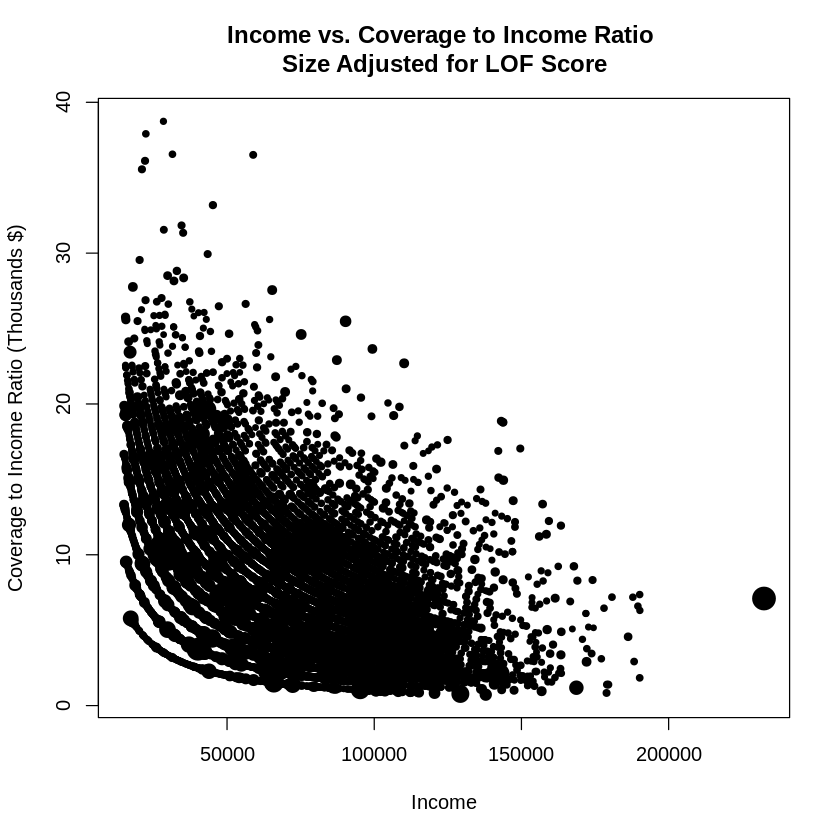

In [73]:
df <- data.frame(income = ins_feat$Income,
                 CIRatio = ins_feat$Cov_Income_Ratio)

ins_lof <- lof(scale(df), k = 5)

df$lof_score <- ins_lof

plot(CIRatio ~ income, data = df, cex = lof_score, pch = 20,
     main = "Income vs. Coverage to Income Ratio \nSize Adjusted for LOF Score",
     xlab = "Income",
     ylab = "Coverage to Income Ratio (Thousands $)")

### Isolation Forest

Instead of distance based measures, now we switch to tree based approaches.

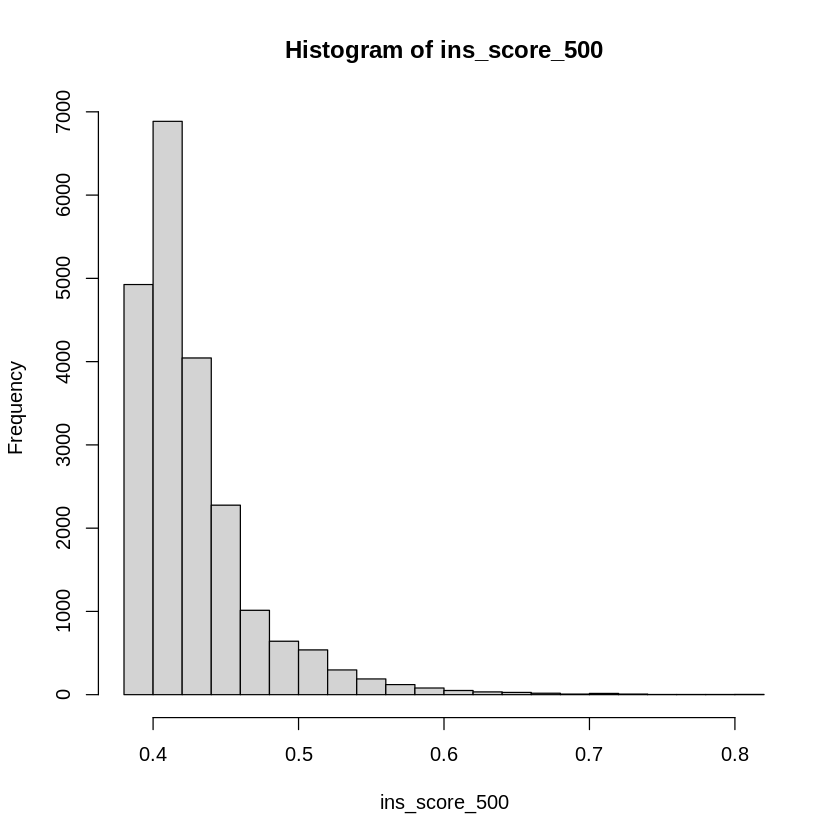

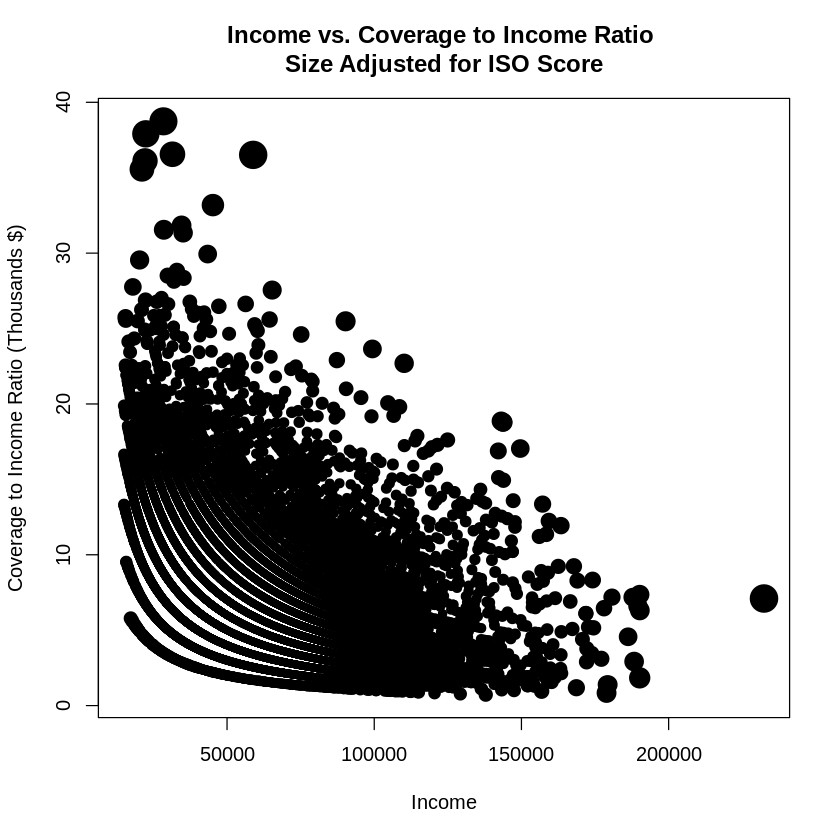

In [78]:
df <- data.frame(income = ins_feat$Income,
                 CIRatio = ins_feat$Cov_Income_Ratio)

#ins_for_100 <- isolation.forest(df = df, ntrees = 100, random_seed = 12345)
ins_for_100 <- isolation.forest(data=df, ntrees = 100)
ins_score_100 <- predict(ins_for_100, df)

#ins_for_500 <- isolation.forest(df = df, ntrees = 500, random_seed = 12345)
ins_for_500 <- isolation.forest(data = df, ntrees = 500)
ins_score_500 <- predict(ins_for_500, df)

hist(ins_score_500)
df$iso_score <- ins_score_500

plot(CIRatio ~ income, data = df, cex = (-1/log(iso_score)), pch = 20,
     main = "Income vs. Coverage to Income Ratio \nSize Adjusted for ISO Score",
     xlab = "Income",
     ylab = "Coverage to Income Ratio (Thousands $)")

### Classifier-Adjusted Density Estimation (CADE)

Let's now finish off with more density based approaches to anomaly detection. Unfortunately, since CADE is so new we need to write it ourselves.

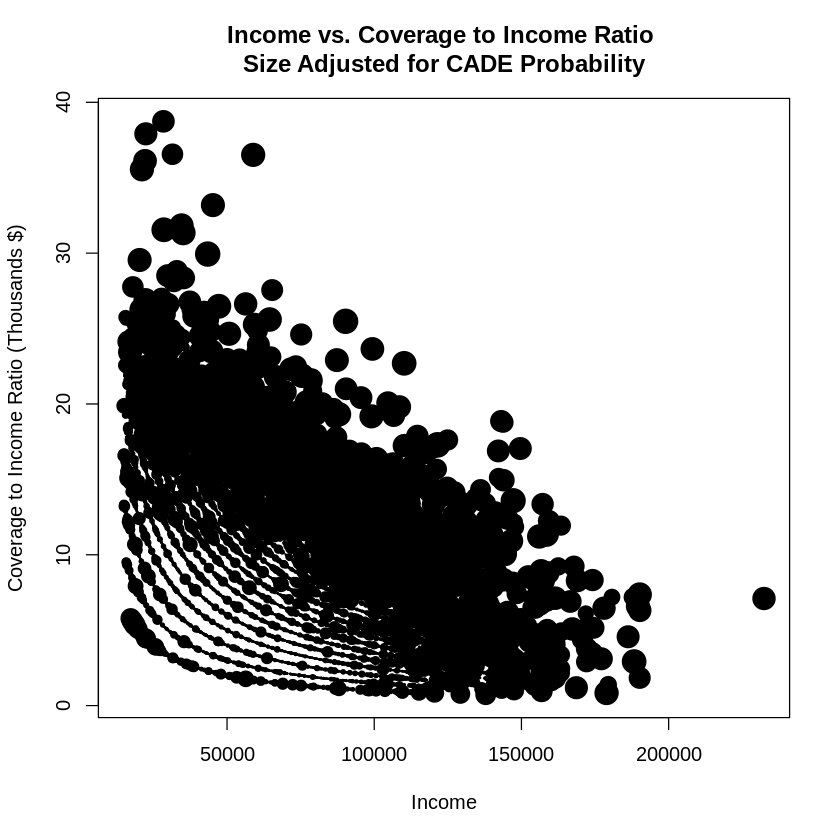

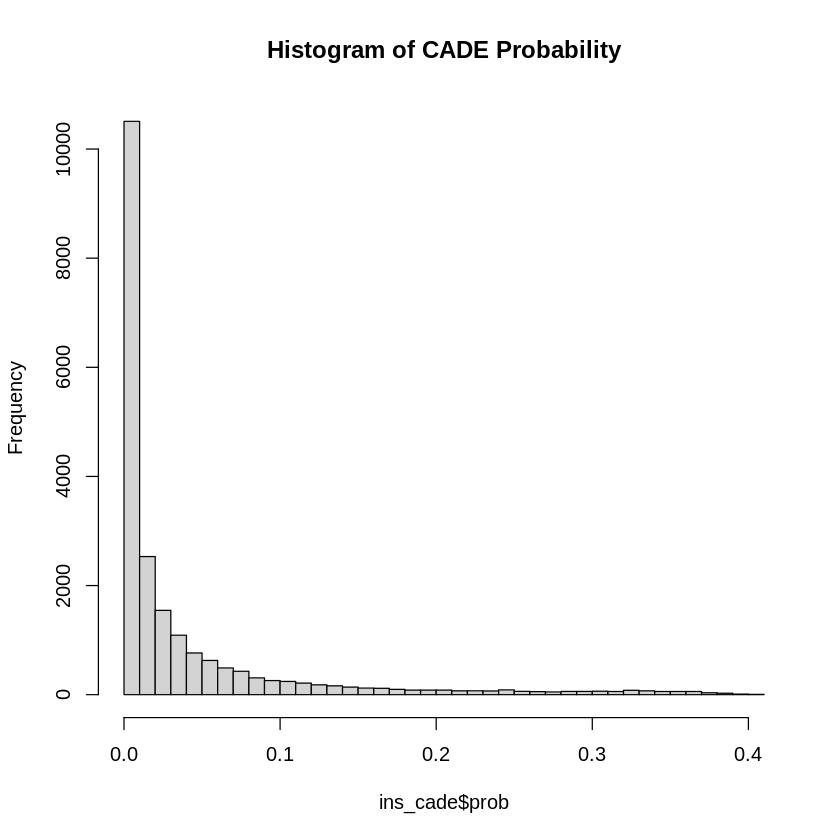

In [79]:
df <- data.frame(income = ins_feat$Income,
                 CIRatio = ins_feat$Cov_Income_Ratio)

trans_uni <- function(x, len = length(x)) {
  if ( is.integer(x) ) {
    sample(min(x):max(x), len, replace = TRUE)
  } else if ( is.numeric(x) ) {
    runif(len, min(x), max(x))
  } else if ( is.factor(x) ) {
    factor(sample(levels(x), len, replace = TRUE))
  } else {
    sample(unique(x), len, replace = TRUE)
  }
}

cade <- function(df, n_tree) {

  actual <- df

  rand <- as.data.frame(lapply(actual, trans_uni))

  actual$y <- 0
  rand$y <- 1

  data <- rbind(actual, rand)

  tree <- randomForest(as.factor(y) ~ ., data = data, ntree = n_tree)

  # The classifier probabilities
  df$prob <- predict(tree, newdata = df, type = 'prob')[, 2]
  df$odds <- df$prob / (1 - df$prob)

  df
}


ins_cade <- cade(df = df, n_tree = 500)

df$prob <- ins_cade$prob
df$odds <- ins_cade$odds

plot(CIRatio ~ income, data = df, cex = prob*10, pch = 20,
     main = "Income vs. Coverage to Income Ratio \nSize Adjusted for CADE Probability",
     xlab = "Income",
     ylab = "Coverage to Income Ratio (Thousands $)")

hist(ins_cade$prob, breaks = 50,
     main = "Histogram of CADE Probability")

### One-Class Support Vector Machines

Lastly, let's look at the support vector machine approach.

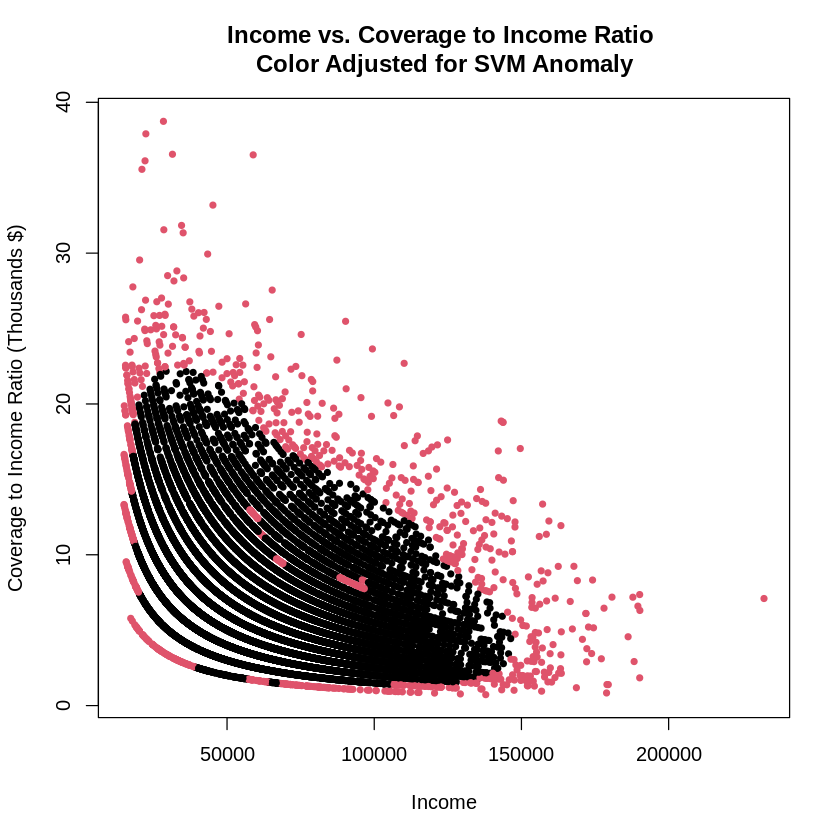

In [80]:
df <- data.frame(income = ins_feat$Income,
                 CIRatio = ins_feat$Cov_Income_Ratio
                )

model <- svm(x = df, y = rep(1, length(ins_feat$Income)), type='one-classification', nu = 0.05)

df$svm <- predict(model, df)

df$svm <- ifelse(df$svm == TRUE, 1, 2)

plot(CIRatio ~ income, data = df, pch = 20, col = df$svm,
     main = "Income vs. Coverage to Income Ratio \nColor Adjusted for SVM Anomaly",
     xlab = "Income",
     ylab = "Coverage to Income Ratio (Thousands $)")